# **Survival Analysis: Brain Cancer**

In this notebook, we will explore the fundamentals of Survival Analysis using the `lifelines` library in Python. Working with a dataset of brain cancer patients, we will learn how to:

*   Estimate Survival Functions using the **Kaplan-Meier estimator.**
* Identify Risk Factors by fitting a **Cox Proportional Hazards** model (`CoxPHFitter`).
* Visualize Results through **survival curves** to interpret the impact of different diagnoses.




In [65]:
%%capture
pip install lifelines

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events

## Brain Cancer Data

The *BrainCancer* dataset contains the survival times for patients with primary brain tumors undergoing treatment with stereotactic radiation methods.

The predictors are:
 gtv (gross tumor volume, in cubic centimeters); sex (male or female);

*   **gtv** (gross tumor volume, in cubic centimeters)
*   **sex** (male or female)
*   **diagnosis** (meningioma, LG glioma, HG glioma, or other)
*   **loc** (the tumor location: either infratentorial or supratentorial)
*   **ki** (Karnofsky index)
*   **stereo** (stereotactic method: either stereotactic radiosurgery or fractionated stereotactic radiotherapy, abbreviated as SRS and SRT, respectively).


This dataset is described in the following paper: *Selingerová et al. (2016) Survival of patients with primary brain tumors: Comparison of two statistical approaches. PLoS One, 11(2):e0148733.*

In [67]:
# Upload BrainCancer.csv Dataset
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()


In [68]:
bc = pd.read_csv('BrainCancer.csv', index_col=0)
bc.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
1,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
2,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
3,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
4,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
5,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


In [69]:
# check for missing value
bc.isnull().sum()

,0
sex,0
diagnosis,1
loc,0
ki,0
gtv,0
stereo,0
status,0
time,0


In [70]:
# fill the missing value with the most frequent value
most_freq_val = bc['diagnosis'].mode()[0]
bc['diagnosis'].fillna(most_freq_val, inplace=True)
bc['diagnosis'].isnull().sum()

np.int64(0)

In [71]:
bc.sex.value_counts()

,count
sex,
Female,45
Male,43


In [72]:
bc.diagnosis.value_counts()

,count
diagnosis,
Meningioma,43
HG glioma,22
Other,14
LG glioma,9


# Censoring
Survival analysis is unique because of **censoring**. We often don't know the exact time of the event for everyone.

> "If Patient #14 is still alive when our study ends at month 50, we cannot say they 'lived for 50 months.' We only know they lived for **at least** 50 months. This is known as **Right-Censoring**."

For example, a patient may leave the study early, or the study may end before the event happens. Censoring is important because survival methods account for these incomplete observations rather than ignoring them.

In [73]:
bc.status.value_counts()

,count
status,
0,53
1,35


Only 53 of the 88 patients were still alive at the end of the study.

`status = 1` indicates an uncensored observation, and `status = 0` indicates a censored observation. But some scientists might use the opposite coding. For the `BrainCancer` data set 35 patients died before the end of the study.

# Kaplan-Meier Survival Curves

The **Kaplan–Meier estimator** is a **non-parametric** method to estimate the probability of survival over time.

It calculates survival probabilities at each observed event time and properly handles censored data, allowing us to visualize how survival changes throughout the study period.

In [74]:
time = bc.time
status = bc.status

kmf = KaplanMeierFitter()
kmf.fit(time, status)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 88 total observations, 53 right-censored observations>

Here `time` corresponds $y_i$, the time to the ith event (either censoring or death)

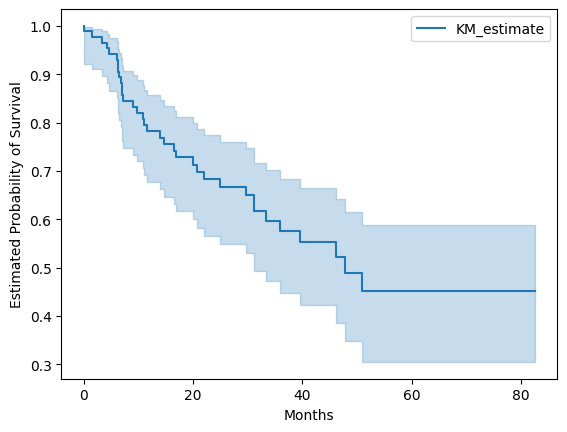

In [75]:
kmf.plot()
plt.xlabel("Months")
plt.ylabel("Estimated Probability of Survival")
plt.show()

Each point in the blue curve shows the estimated
probability of surviving past the time indicated on the horizontal axis. The
estimated probability of survival past 20 months is 71%.



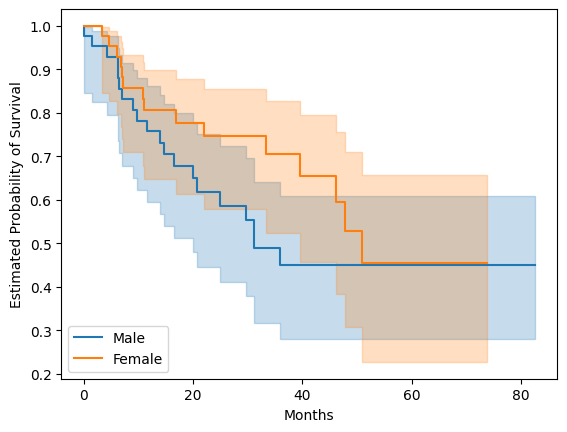

In [76]:
# Kaplan-Meier survival curves that are stratified by sex
groups = set(bc.sex)
fit_sex = KaplanMeierFitter()

for group in groups:
    ix = (bc.sex == group)
    fit_sex.fit(time[ix], status[ix])
    fit_sex.plot(label=group)

# Plot settings
plt.xlabel("Months")
plt.ylabel("Estimated Probability of Survival")
plt.legend(loc="lower left")
plt.show()

# Log-rank test
We wish to compare the survival of males to that of females.

Figure above shows the Kaplan–Meier survival curves for the two groups.
Females seem to fare a little better up to about 50 months, but then the
two curves both level off to about 50%.

**How can we carry out a formal test of equality of the two survival curves?**
At first glance, a two-sample t-test seems like an obvious choice: we could
test whether the mean survival time among the females equals the mean
survival time among the males. But the presence of censoring creates
a complication. To overcome this challenge, we will conduct a **log-rank test**, which examines how the events in each group unfold sequentially in time.

In [77]:
# We perform a log-rank test to compare the survival of males to females
result = logrank_test(bc.time[bc.sex == 'Male'], bc.time[bc.sex == 'Female'],
                      bc.status[bc.sex == 'Male'], bc.status[bc.sex == 'Female'])

print('Log-Rank Test Statistic: ', result.test_statistic)
print('Log-Rank Test p-value: ', result.p_value)

Log-Rank Test Statistic:  1.440495107079581
Log-Rank Test p-value:  0.23005923816839605


The resulting p-value is 0.23, indicating no evidence of a difference in survival between the two sexes.

# Cox Proportional Hazards
The **Cox Proportional Hazards** model is a **semi-parametric** method used to assess the effect of one or more predictors on survival.

Unlike Kaplan–Meier, it can adjust for covariates and estimate the relative risk (**hazard ratio**) associated with each predictor.

Here, we fit a Cox model to evaluate the effect of sex on survival, while accounting for censored observations.

The **Hazard Ratio** represents the relative risk of the event (*death*) occurring.

* **$HR = 1$**: **Neutral.** The factor has no effect on the risk of death.
* **$HR > 1$**: **Increased Risk.** The factor is associated with a higher risk (shorter survival).
* **$HR < 1$**: **Protective Effect.** The factor reduces the risk (longer survival).

In [78]:
# Fit Cox Proportional Hazards

cph = CoxPHFitter()
cph.fit(bc, duration_col='time', event_col='status', formula='sex')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2026-02-13 12:44:27 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
sex[T.Male]  0.41      1.50      0.34           -0.26            1.08                0.77                2.94

             cmp to    z    p  -log2(p)
covariate                              
sex[T.Male]    0.00 1.19 0.23      2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

In this initial step, we isolate the effect of biological sex on survival outcomes. Here is how to interpret the output:

* **Hazard Ratio** (exp(coef) = 1.50): At first glance, the model suggests that males have a 50% higher risk of the event (*death*) at any given time compared to females.

* **Statistical Significance** (p-value = 0.23): However, because the p-value is greater than 0.05, this difference is not statistically significant.

* **Confidence Interval** (0.77 to 2.94): The 95% confidence interval for the Hazard Ratio includes 1.0, which means we cannot rule out the possibility that there is no difference at all between the sexes.

* **Concordance** (0.56): A score of 0.56 is only slightly better than a random guess (0.50), indicating that `sex` alone is a poor predictor of survival in this dataset.

Although there is no clear evidence of a survival difference between males and females when analyzed in isolation (p = 0.23), this does not mean other factors are not at play. Survival in brain cancer is often driven by a complex interaction of tumor pathology and clinical markers. To obtain a more accurate picture, we now extend the analysis by incorporating additional clinical predictors into a multivariable survival model, such as `diagnosis type`, `Karnofsky index (ki)`, and `tumor volume (gtv)`.



# Multivariate Cox Proportional Hazards Model

In our previous analysis, we observed that biological sex alone did not significantly impact survival. However, medical outcomes are rarely determined by a single factor. To understand the true drivers of survival in brain cancer patients, we must account for clinical markers, tumor characteristics, and treatment types simultaneously.


Since the Cox model requires numerical inputs, we must transform our categorical variables (Diagnosis, Sex, etc.) into "dummy" variables. We use pd.get_dummies() to transform these into binary (0 or 1) variables.

We explicitly drop one category for each variable to serve as our **Reference Group**. In clinical research, this is a strategic choice:
* We drop `diagnosis_Meningioma` because it has the most favorable prognosis.
* By doing this, the model will tell us how much the risk increases for other diagnoses **compared to the best-case scenario (Meningioma)**. This is a standard and logical clinical practice.

In [79]:
# Create dummy (one-hot encoded) variables for categorical predictors
# Remove one category per variable to define reference groups

dummies_bc = pd.get_dummies(bc.loc[:, ['diagnosis', 'sex', 'loc', 'stereo']])
dummies_bc.drop(['diagnosis_Meningioma', 'sex_Female', 'loc_Infratentorial', 'stereo_SRS'],
                inplace=True, axis=1)
dummies_bc.head()

,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Other,sex_Male,loc_Supratentorial,stereo_SRT
1,False,False,False,False,False,False
2,True,False,False,True,True,True
3,False,False,False,False,False,False
4,False,True,False,False,True,True
5,True,False,False,True,True,True


In [80]:
# Remove original categorical variables (already dummy-coded)
# Concatenating with Original Data

bc.drop(['diagnosis', 'sex', 'loc', 'stereo'], inplace=True, axis=1)
bc = pd.concat([bc, dummies_bc], axis=1)
bc.head()

,ki,gtv,status,time,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Other,sex_Male,loc_Supratentorial,stereo_SRT
1,90,6.11,0,57.64,False,False,False,False,False,False
2,90,19.35,1,8.98,True,False,False,True,True,True
3,70,7.95,0,26.46,False,False,False,False,False,False
4,80,7.61,1,47.80,False,True,False,False,True,True
5,90,5.06,1,6.30,True,False,False,True,True,True


In [81]:
# Clean column names for compatibility with model formula
columns = bc.columns
columns = [column.replace(' ', '_') for column in columns]
bc.columns = columns

By fitting this multivariable model, we can determine the independent effect of each variable while "holding the others constant." This allows us to answer critical clinical questions, such as:

* Is the higher risk in high-grade gliomas due to the tumor type itself, or is it because those tumors tend to have a larger volume `(gtv)`?

* Does a specific treatment (stereo_SRT) offer a survival advantage after adjusting for the patient's initial health status `(ki)`?

In [82]:
# Fit a multivariable Cox proportional hazards model
# Estimate the independent effect of each predictor on survival

cph_all = CoxPHFitter()
cph_all.fit(bc, duration_col='time', event_col='status',
            formula='sex_Male + diagnosis_HG_glioma + diagnosis_LG_glioma + diagnosis_Other + loc_Supratentorial + ki + gtv + stereo_SRT')
cph_all.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -116.96
         time fit was run = 2026-02-13 12:44:27 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
sex_Male             0.17      1.18      0.36           -0.54            0.87                0.58                2.39
diagnosis_HG_glioma  2.19      8.91      0.45            1.31            3.07                3.70               21.44
diagnosis_LG_glioma  0.95      2.59      0.64           -0.29            2.20                0.75                9.01
diagnosis_Other      0.91      2.48      0.66           -0.39            2.20                0.68                9.02
loc_Supratentorial   0.43      1.54      0.71           -0.95            1.82                0.39                6.15
ki                  -0.06      0.95      0.02           -0.09           -0.02                0.91                0.98
gtv                  0.03      1.04      0.02           -0.01            0.08                0.99                1.08
stereo_SRT           0.16      1.18      0.60           -1.02            1.34                0.36                3.83

                     cmp to     z      p  -log2(p)
covariate                                         
sex_Male               0.00  0.47   0.64      0.64
diagnosis_HG_glioma    0.00  4.88 <0.005     19.85
diagnosis_LG_glioma    0.00  1.50   0.13      2.91
diagnosis_Other        0.00  1.37   0.17      2.56
loc_Supratentorial     0.00  0.61   0.54      0.89
ki                     0.00 -3.04 <0.005      8.72
gtv                    0.00  1.54   0.12      3.03
stereo_SRT             0.00  0.27   0.79      0.35
---
Concordance = 0.80
Partial AIC = 249.92
log-likelihood ratio test = 42.38 on 8 df
-log2(p) of ll-ratio test = 19.73


### 1. `Diagnosis`

The type of tumor is the strongest predictor of survival. Since we used **Meningioma** as the reference group:

* **High-Grade (HG) Glioma:** This is the most critical risk factor. The coefficient of **2.19** translates to a **Hazard Ratio (HR) of 8.91** . This means that, holding all other factors constant, patients with HG glioma face a risk of death nearly **9 times higher** than those with Meningioma.
* **LG Glioma and Other:** While these show higher Hazard Ratios (2.59 and 2.48 respectively), their p-values (0.13 and 0.17) suggest that the difference compared to Meningioma is not statistically significant in this specific sample.

### 2. `The Karnofsky Index (ki)`

The **ki** variable measures a patient's functional status (their ability to perform daily activities).

* **Coefficient = -0.06:** The negative sign is crucial. It means that as the index **increases** (better health), the risk of death **decreases**.
* **Interpretation:** For every 1-point increase in the Karnofsky score, the hazard of death drops by about **5%**. This confirms that patients who are physically stronger at the start of the study have significantly better survival prospects.

### 3. Non-Significant Variables: `Sex`, `Location`, and `Treatment`

Interestingly, several factors that we might expect to matter did not show statistical significance in this multivariable context:

* **Sex_Male (p=0.64):** Once we account for diagnosis and health status (ki), being male or female does not create a meaningful difference in survival.
* **Tumor Volume (gtv, p=0.12):** Although a larger tumor usually implies higher risk (HR 1.04), it doesn't reach the significance threshold here, likely because its effect is already captured by the **Diagnosis** type.
* **Treatment (stereo_SRT, p=0.79):** The specific radiation therapy (SRT vs SRS) did not show a significant survival advantage in this model.


To asses model performance, we look at the **Concordance** value in the summary table.

Think of the **C-index** as the $R^2$ of survival analysis. A value of **0.80** indicates that our model is highly effective: it can correctly predict which of two random patients will experience the event first in **80% of cases**.  


# Survival Curves by Diagnosis

To visualize how diagnosis affects survival, we create a set of hypothetical patients. To ensure our comparison is fair, we use a **Representative Profile**:

* Instead of choosing arbitrary values, we use the **Population Mode** (the most frequent value) for categorical variables like Sex and Location.
* For numerical variables, we use the **Population Mean**.

This ensures our prediction reflects a "typical" patient from our dataset, making the results highly relevant for clinical decision-making.


Therefore, we construct **four hypothetical "modal" patients**. The goal is to isolate the effect of the **diagnosis** by ensuring that all other characteristics are identical across the four subjects:

* **Quantitative variables (`ki` and `gtv`):** These are fixed at the dataset's **mean** values.
* **Categorical variables (`sex`, `loc`, `stereo`):** These are set to their **modal** (most common) values (e.g., Supratentorial location and SRT treatment).

By "freezing" these covariates, we create a controlled environment. Any difference we see in the resulting curves will be strictly due to the diagnosis category, providing a clear comparison of how **HG Glioma**, **LG Glioma**, and **Other** diagnoses fare against the baseline **Meningioma**.


In [83]:
# plot survival curves for each diagnosis category
# set the values of the other predictors equal to the mean for quantitative variables,
# and the modal value for factors

modaldata = pd.DataFrame({
    'diagnosis_HG_glioma' : np.array([0, 1, 0, 0]),
    'diagnosis_LG_glioma' : np.array([0, 0, 1, 0]),
    'diagnosis_Other' : np.array([0, 0, 0, 1]),
    'sex_Male' : np.zeros((4, )),
    'loc_Supratentorial' : np.ones((4, )),
    'ki' : [bc.ki.mean()] * 4,
    'gtv' : [bc.gtv.mean()] * 4,
    'stereo_SRT' : np.ones((4, ))
})

modaldata.head()

,diagnosis_HG_glioma,diagnosis_LG_glioma,diagnosis_Other,sex_Male,loc_Supratentorial,ki,gtv,stereo_SRT
0,0,0,0,0.0,1.0,81.022727,8.660795,1.0
1,1,0,0,0.0,1.0,81.022727,8.660795,1.0
2,0,1,0,0.0,1.0,81.022727,8.660795,1.0
3,0,0,1,0.0,1.0,81.022727,8.660795,1.0


Using the fitted Cox proportional hazards model, we now estimate the predicted survival functions for each of the four hypothetical patients. These predicted survival probabilities represent model-based survival curves adjusted for all other covariates in the model.

Finally, we plot the estimated survival curves for each diagnosis group. The curves represent adjusted survival probabilities over time, allowing us to compare the effect of diagnosis while holding the other predictors constant.

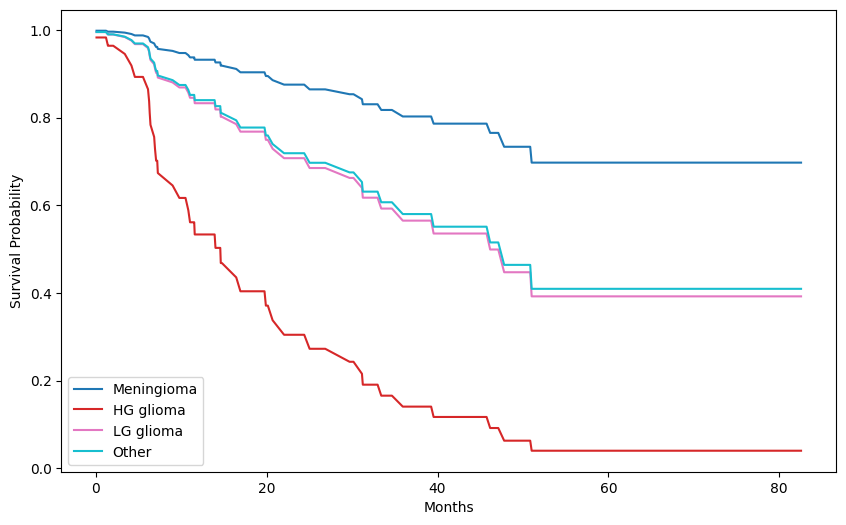

In [84]:
# Assuming 'cph_all' is the fitted CoxPHFitter model
survival_probs = cph_all.predict_survival_function(modaldata)
diagnosis_names = ["Meningioma", "HG glioma", "LG glioma", "Other"]

plt.figure(figsize=(10, 6))

color_palette = plt.cm.get_cmap("tab10", len(diagnosis_names))

for i, (diagnosis, row) in enumerate(modaldata.iterrows()):
    cumulative_hazard = cph_all.predict_cumulative_hazard(row)
    survival_prob = np.exp(-cumulative_hazard)
    plt.plot(cumulative_hazard.index, survival_prob, label=diagnosis_names[diagnosis], color=color_palette(i))

plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.legend(loc="lower left")

plt.show()




The Figure above illustrates the **predicted survival probabilities** for our four hypothetical "modal" patients. By holding all other clinical variables constant (mean age, mean tumor volume, etc.), the visible gaps between the curves represent the pure effect of the **diagnosis** on patient outcomes.

* **Meningioma (Blue Curve):** This group shows the most favorable prognosis. The curve remains the highest throughout the study period, indicating that these patients have the highest probability of survival over time.
* **HG Glioma (Red Curve):** This curve drops much more steeply than the others. This visualization perfectly matches our Cox model's Hazard Ratio of **8.91**. It clearly shows that patients with High-Grade Glioma face a significantly higher risk of the event occurring much earlier in the follow-up period.
* **LG Glioma & Other (Pink and Cyan Curves):** These two curves track very closely to each other. Their intermediate position confirms that while they carry a higher risk than Meningioma, their prognosis is substantially better than that of High-Grade Glioma.


The visual evidence confirms that **tumor grade** is a dominant predictor of survival. For a "typical" patient in this dataset, the difference between a Meningioma and an HG Glioma diagnosis represents a drop in 50-month survival probability from roughly **70%** to nearly **5%**.
